# Activities Classification with Explainable AI (XAI)

<!-- ![title](Figure_2.png) -->

In [40]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import clone_model
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import random

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


## Opening the files
Load the training/testing dataset from csv files
first column: ID
last column: the expected output, for example: 1, 2, 3, corresponds to one of 3 activities
+ 1: web browsing/file downloading
+ 2: online communication, like video call
+ 3: online video watching

In [58]:
# Load the training/testing dataset from csv files
training_dataset = pd.read_csv("../../output_train.csv", header=0, usecols=[*range(1,23)], sep=";")
testing_dataset = pd.read_csv("../../output_test.csv", header=0, usecols=[*range(1,23)], sep=";")

poison_dataset = pd.read_csv("../../poison/generated-5000.csv")

# Remove missing values
training_dataset.dropna(axis = 0, inplace = True)
testing_dataset.dropna(axis = 0, inplace = True)
poison_dataset.dropna(axis = 0, inplace=True)

print("The shape of the training dataset: " + str(training_dataset.shape))
print("The shape of the testing dataset: " + str(testing_dataset.shape))
print("The shape of the testing dataset: " + str(poison_dataset.shape))

training_dataset.head()

The shape of the training dataset: (279, 22)
The shape of the testing dataset: (103, 22)
The shape of the testing dataset: (5000, 22)


,session_time,%tcp_protocol,%udp_protocol,ul_data_volume,max_ul_volume,min_ul_volume,avg_ul_volume,std_ul_volume,%ul_volume,dl_data_volume,...,avg_dl_volume,std_dl_volume,%dl_volume,nb_uplink_packet,nb_downlink_packet,ul_packet,dl_packet,kB/s,nb_packet/s,output
0,4.999674,100.000000,0.000000,99090,54,54,54.000000,0.000000,1.652834,5896066,...,1564.358185,313.304936,98.347166,1835,3769,32.744468,67.255532,1199.109362,1120.873063,1
1,0.892125,100.000000,0.000000,32184,54,54,54.000000,0.000000,1.673617,1890837,...,1594.297639,601.903863,98.326383,596,1186,33.445567,66.554433,2155.550758,1997.477642,1
2,3.412767,99.857265,0.142735,77133,471,54,55.213314,18.696881,2.276791,3310662,...,1571.268154,562.653689,97.723209,1397,2107,39.868721,60.131279,992.682790,1026.732873,1
3,4.999285,99.888471,0.111529,142985,471,54,54.699694,14.495354,1.925924,7281243,...,1597.114060,649.341567,98.074076,2614,4559,36.442214,63.557786,1485.057968,1434.805182,1
4,1.682172,100.000000,0.000000,60534,54,54,54.000000,0.000000,1.571208,3792170,...,1645.907118,1250.277675,98.428792,1121,2304,32.729927,67.270073,2290.315058,2036.058071,1


In [46]:
# Set of features in the dataset
features = list(testing_dataset.columns)
print(features[:-1])

['session_time', '%tcp_protocol', '%udp_protocol', 'ul_data_volume', 'max_ul_volume', 'min_ul_volume', 'avg_ul_volume', 'std_ul_volume', '%ul_volume', 'dl_data_volume', 'max_dl_volume', 'min_dl_volume', 'avg_dl_volume', 'std_dl_volume', '%dl_volume', 'nb_uplink_packet', 'nb_downlink_packet', 'ul_packet', 'dl_packet', 'kB/s', 'nb_packet/s']


In [60]:
# Convert the expected output into arrays, e.g., 1 -> [1, 0, 0]
output_training = []
for i, val in enumerate(training_dataset.iloc[:,21]):
    temp = [0, 0, 0]
    temp[val - 1] = 1
    output_training.append(temp)

output_testing = []
for i, val in enumerate(testing_dataset.iloc[:,21]):
    temp = [0, 0, 0]
    temp[val - 1] = 1
    output_testing.append(temp)

output_poisoning = []
for i, val in enumerate(poison_dataset.iloc[:,-1]):
    temp = [0, 0, 0]
    temp[int(val) - 1] = 1
    output_poisoning.append(temp)

# Remove the expected output column from the datasets
prep_training_dataset = training_dataset.drop(columns=['output'])
prep_testing_dataset = testing_dataset.drop(columns=['output'])

prep_poison_dataset = poison_dataset.drop(poison_dataset.columns[-1],axis=1)

# Preprocessing the data
scaler = StandardScaler()
scaler.fit(prep_training_dataset)
# scaler.fit(prep_poison_dataset)

# Apply transform to both the training/testing dataset.
X_train = scaler.transform(prep_training_dataset)
Y_train = np.array(output_training)

X_test = scaler.transform(prep_testing_dataset)
Y_test = np.array(output_testing)

X_poison = scaler.transform(prep_poison_dataset)
Y_poison = np.array(output_poisoning)

print("Preprocessed inputs of the training dataset: " + str(X_train))
print("Preprocessed outputs of the training dataset: " + str(Y_train))
# print("Preprocessed outputs of the poisoning dataset: " + str(Y_train))

Preprocessed inputs of the training dataset: [[ 1.24949172  0.59231316 -0.58844871 ...  0.54501086  0.2208743
   0.62843195]
 [-0.8505485   0.59231316 -0.58844871 ...  0.4955518   0.97523057
   1.92817113]
 [ 0.43816388  0.5886868  -0.58480418 ...  0.04242978  0.0580633
   0.48885055]
 ...
 [-1.2056687   0.34743347 -0.34234218 ... -0.71477922 -0.56070378
  -0.41047599]
 [-0.89460259  0.58409106 -0.58018542 ...  0.10394211  0.44768975
   1.24034932]
 [-0.98176026  0.59231316 -0.58844871 ... -0.62260254  0.43111073
  -0.53651579]]
Preprocessed outputs of the training dataset: [[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0

In [424]:
len(X_train)

279

In [483]:
'''
This function creates the poisoning values based on poison type
type:
- new_example: add new examples of data from a given poison dataset. 
- random_swapping: Randomly swap labels from one class to another.
- targeted_flipping: Flip the labels based on a target_bias_class. Here a class value should be given for target_bias_class.
'''
def get_poison_set(X_train, Y_train, X_poison=None, Y_poison=None, poison_type='new_example', percentage=0, target_bias_class=None):
    X_train_ = X_train.copy().tolist()
    Y_train_ = Y_train.copy().tolist()
    poison_count = -1
    original_count = -1
    if poison_type=='new_example':
        required_samples = int(len(X_train_)*percentage*0.01)
        original_count = len(X_train)
        poison_count = required_samples
        # if len(X_poison)>=required_samples:
        to_copy_idx =[i for i in range(len(X_poison))]
        random.shuffle(to_copy_idx)
        for i in range(required_samples):
            X_train_.append(X_poison[to_copy_idx[i]])
            Y_train_.append(Y_poison[to_copy_idx[i]])

    if poison_type=='existing_example':
        required_samples = int(len(X_train_)*percentage*0.01)
        original_count = len(X_train)
        poison_count = len(X_train) - required_samples
        # if len(X_poison)>=required_samples:
        to_copy_idx =[i for i in range(len(X_poison))]
        flip_idx = random.randint(0,len(X_train_)-1)
        random.shuffle(to_copy_idx)
        for i in range(required_samples):
            X_train[flip_idx] = X_poison[to_copy_idx[i]]
            Y_train[flip_idx] = Y_poison[to_copy_idx[i]]
        
        
    elif poison_type=='random_swapping':
        flip_amount = int(len(X_train_)*percentage*0.01)
        original_count = len(X_train) - flip_amount
        poison_count = flip_amount

        print(len(X_train_)>=flip_amount)
        if len(X_train_)>=flip_amount:
            for i in range(flip_amount):
                flip_idx_1 = random.randint(0,len(Y_train_)-1)
                flip_idx_2 = random.randint(0,len(Y_train_)-1)
                Y_train_[flip_idx_1], Y_train_[flip_idx_2] = Y_train_[flip_idx_2], Y_train_[flip_idx_1]

    elif poison_type=='targeted_flipping':
        flip_amount = int(len(X_train_)*percentage*0.01)
        original_count = len(X_train) - flip_amount
        poison_count = flip_amount
        flip_amount = int(len(X_train_)*percentage*0.01)
        if len(X_train_)>=flip_amount:
            for i in range(flip_amount):
                flip_idx_1 = random.randint(0,len(Y_train_)-1)
                Y_train_[flip_idx_1] = target_bias_class
        
        else:
            raise Exception('Poison percentage should not exceed 100 percent')
    else: 
        raise Exception('Cannot recognize poison_type. It should be in one of the followings: new_example, random_swapping, and targeted_flipping')
            
    return np.asarray(X_train_), np.asarray(Y_train_), poison_count, original_count

In [318]:
def impact_metric_spatial(FP, F, is_F1=False):
    if is_F1:
        FP = 1-FP
        F = 1-F
        
    return (FP-F)/F

In [319]:
def complexity_spatial(DP, D):
    return DP/(D + DP)

In [320]:
def evaluate_spatial_metrics_poison_impact(X_test, Y_test, ct_poison, ct_original, model, model_poison):  
    
    # evaluating without poisoning 
    _, accuracy_original = model.evaluate(X_test, Y_test)
    # Evaluate the Keras model
    _, accuracy_poisoned = model_poison.evaluate(X_test, Y_test)

    # Make class predictions with the models
    predictions_original = (model.predict(X_test) > 0.5).astype(int)
    predictions_poisoned = (model_poison.predict(X_test) > 0.5).astype(int)

    f1_original = f1_score(Y_test, predictions_original, average="macro")
    f1_poisoned = f1_score(Y_test, predictions_poisoned, average="macro")
    
    # impact metric
    print('accuracy original: %.2f'% (accuracy_original))
    print('accuracy poisoned: %.2f'% (accuracy_poisoned))
    print('f1 original: %.2f'% (f1_original))
    print('f1 poisoned: %.2f'% (f1_poisoned))

    impact = impact_metric_spatial(f1_poisoned, f1_original, is_F1=True)
    complexity = complexity_spatial(ct_poison,ct_original)
    
    return impact, complexity, accuracy_original, accuracy_poisoned, f1_original, f1_poisoned

In [321]:
def get_models_for_attack(epochs=150, verbose=0):
    model = Sequential()
    model.add(Dense(12, input_shape=(21,), activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))

    # Compile the Keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model_cp = clone_model(model)
    model_cp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, Y_train, epochs=epochs, batch_size=10, verbose=verbose)
    return model, model_cp

In [322]:
# model, model_cp = get_models_for_attack()
# impact,complexity,_,_,_,_ = evaluate_spatial_metrics_poison_impact(
#     X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, X_poison=X_poison, Y_poison=Y_poison, 
#     poison_percentage=10, poison_type='new_example', model=model, model_poison=model_cp, train_epochs=150, batch_size=10, 
#     is_trained_model_available = True, verbose=0)
# print(impact)
# print(complexity)

In [323]:
'''types:
- new_example: add new examples of data from a given poison dataset. 
- random_swapping: Randomly swap labels from one class to another.
- targeted_flipping: Flip the labels based on a target_bias_class. Here a class value should be given for target_bias_class.
'''
def get_impact_over_range_of_poisoning(poison_range, num_exp, poison_type='new_example', epochs=100, batch_size=10, verbose=0, target_bias_class=None):
    impact_vals = []
    accuracy_vals = []
    complexity_vals = []
    for i in range(num_exp):
        print('running experiment: %d'%(i))
        per_exp_round = []
        complexity_round = []
        for poison_percent in poison_range:
            print('poisoning percentage: %d'%(poison_percent))
            # poisoning a model
            model, model_cp = get_models_for_attack(epochs=epochs, verbose=0)
            X_train_new, Y_train_new, ct_poison, ct_original = get_poison_set(X_train, Y_train, X_poison, Y_poison, 
                poison_type=poison_type, percentage=poison_percent,target_bias_class=target_bias_class)
            model_cp.fit(X_train_new, Y_train_new, epochs=epochs, batch_size=batch_size, verbose=verbose)

            impact,complexity,_,_,_,_ = evaluate_spatial_metrics_poison_impact(X_test=X_test, Y_test=Y_test,  
            ct_poison=ct_poison, ct_original=ct_original, model=model, model_poison=model_cp)
            per_exp_round.append(impact)
            complexity_round.append(complexity)

        impact_vals.append(per_exp_round)
        complexity_vals.append(complexity_round)

    return impact_vals, complexity_vals


In [325]:
# impacts, complexity = get_impact_over_range_of_poisoning(poison_range=[10,20,30,40,50,60,70,80,90,100], num_exp=5, poison_type='new_example',target_bias_class=None)

In [326]:
# avg=np.average(np.array(impacts), axis=0)
# stdev=np.std(np.array(impacts), axis=0)
# complexity_avg = np.average(np.array(complexity), axis=0)

In [ ]:
def draw_graph(x, y_list, err_list, xlabel, ylabel, xlim, ylim=[0,1], label_list=[], is_legend=True, legend_loc ='upper right', 
               facecolor_list=[], edgecolor_list=[], alpha=0.4, contains_label=True, grid_on=True, thresh_on=True, thresh_val = 0.5):
  for i in range(len(y_list)):
    y1 = y_list[i]
    y_error = err_list[i]
    y_min = [y1[j]-y_error[j] for j in range(len(y1))]
    y_max = [y1[j]+y_error[j] for j in range(len(y1))]

    facecolor = generate_rand_color()
    edgecolor = generate_rand_color()
    if len(facecolor_list)!=0 and len(edgecolor_list)!=0:
      facecolor = facecolor_list[i]
      edgecolor = edgecolor_list[i]
    if len(label_list)!=0:
      plt.plot(x, y1, color=facecolor,label=label_list[i])
    else:
      plt.plot(x, y1, color=facecolor)

    plt.fill_between(x, y_min, y_max,
      alpha=alpha, edgecolor=edgecolor, facecolor=facecolor)
    
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.ylim(ylim)
  plt.xlim(xlim)

  plt.locator_params(axis="x", integer=True, tight=True)
  plt.rc('grid', linestyle="--", color='grey')
  plt.grid(grid_on)
  plt.xticks(x)

  if thresh_on:  
    plt.axhline(y=thresh_val, color='#fa7e61', linestyle='--')
  
  if len(label_list)!=0 and is_legend:
    plt.legend( loc=legend_loc)
  
  plt.show()

def generate_rand_color():
    return "#%06x" % random.randint(0, 0xFFFFFF)


In [390]:
def draw_graph_diff_x_plots(x_list, y_list, err_list, xlabel, ylabel, xlim, ylim=[0,1], label_list=[], is_legend=True, legend_loc ='upper right', 
               facecolor_list=[], edgecolor_list=[], alpha=0.4, contains_label=True, grid_on=True, thresh_on=True, thresh_val = 0.5):
  for i in range(len(y_list)):
    y1 = y_list[i]
    y_error = err_list[i]
    y_min = [y1[j]-y_error[j] for j in range(len(y1))]
    y_max = [y1[j]+y_error[j] for j in range(len(y1))]

    facecolor = generate_rand_color()
    edgecolor = generate_rand_color()
    if len(facecolor_list)!=0 and len(edgecolor_list)!=0:
      facecolor = facecolor_list[i]
      edgecolor = edgecolor_list[i]
    if len(label_list)!=0:
      plt.plot(x_list[i], y1, color=facecolor,label=label_list[i])
    else:
      plt.plot(x_list[i], y1, color=facecolor)

    plt.fill_between(x_list[i], y_min, y_max,
      alpha=alpha, edgecolor=edgecolor, facecolor=facecolor)
    
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.ylim(ylim)
  plt.xlim(xlim)

  plt.locator_params(axis="x", integer=True, tight=True)
  plt.rc('grid', linestyle="--", color='grey')
  plt.grid(grid_on)
  plt.xticks(x_list[i])

  if thresh_on:  
    plt.axhline(y=thresh_val, color='#fa7e61', linestyle='--')
  
  if len(label_list)!=0 and is_legend:
    plt.legend( loc=legend_loc)
  
  plt.show()

def generate_rand_color():
    return "#%06x" % random.randint(0, 0xFFFFFF)


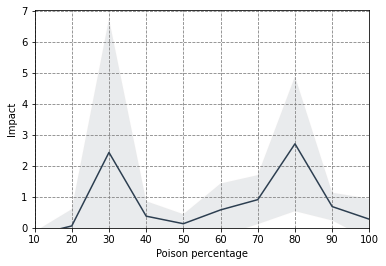

In [ ]:
# draw_graph(x=[10,20,30,40,50,60,70,80,90,100], y_list = [avg], 
#            err_list = [stdev], xlabel = "Poison percentage", 
#            ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg)+max(stdev)], 
#            is_legend=False, facecolor_list=['#2C3E50','#6C3483','#27AE60','#E67E22'], 
#            edgecolor_list=['#F9EBEA','#F8F9F9','#EBF5FB','#E9F7EF'], alpha=0.1, thresh_on=False)

In [ ]:
'''types:
- new_example: add new examples of data from a given poison dataset. 
- random_swapping: Randomly swap labels from one class to another.
- targeted_flipping: Flip the labels based on a target_bias_class. Here a class value should be given for target_bias_class.
'''

impacts_new, complexity_new = get_impact_over_range_of_poisoning(poison_range=[10,25,50,75,100], num_exp=5, poison_type='new_example',target_bias_class=None)

running experiment: 0
poisoning percentage: 10
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.96
accuracy poisoned: 0.97
f1 original: 0.93
f1 poisoned: 0.93
poisoning percentage: 25
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.96
accuracy poisoned: 0.95
f1 original: 0.93
f1 poisoned: 0.87
poisoning percentage: 50
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.96
accuracy poisoned: 0.95
f1 original: 0.89
f1 poisoned: 0.87
poisoning percentage: 75
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.95
accuracy poisoned: 0.96
f1 original: 0.91
f1 poisoned: 0.91
poisoning percentage: 100
4/4 [==============================] - 0s 2ms/step
accuracy original: 0.97
accuracy poisoned: 0.96
f1 original: 0.93
f1 poisoned: 0.88
running experiment: 1
poisoning percentage: 10
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.96
accuracy poisoned: 0.95
f1 original: 0.90
f1 poisoned: 

In [491]:
impacts_existing, complexity_existing = get_impact_over_range_of_poisoning(poison_range=[10,25,50,75,100], num_exp=5, poison_type='existing_example',target_bias_class=None)

running experiment: 0
poisoning percentage: 10
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.93
accuracy poisoned: 0.94
f1 original: 0.86
f1 poisoned: 0.85
poisoning percentage: 25
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.93
accuracy poisoned: 0.95
f1 original: 0.86
f1 poisoned: 0.89
poisoning percentage: 50
4/4 [==============================] - 0s 983us/step
accuracy original: 0.96
accuracy poisoned: 0.94
f1 original: 0.87
f1 poisoned: 0.89
poisoning percentage: 75
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.95
accuracy poisoned: 0.96
f1 original: 0.84
f1 poisoned: 0.91
poisoning percentage: 100
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.96
accuracy poisoned: 0.96
f1 original: 0.90
f1 poisoned: 0.92
running experiment: 1
poisoning percentage: 10
4/4 [==============================] - 0s 987us/step
accuracy original: 0.93
accuracy poisoned: 0.97
f1 original: 0.82
f1 poison

In [ ]:
impacts_swap, complexity_swap = get_impact_over_range_of_poisoning(poison_range=[10,25,50,75,100], num_exp=5, poison_type='random_swapping',target_bias_class=None)

running experiment: 0
poisoning percentage: 10
True
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.97
accuracy poisoned: 0.95
f1 original: 0.87
f1 poisoned: 0.90
poisoning percentage: 25
True
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.97
accuracy poisoned: 0.90
f1 original: 0.96
f1 poisoned: 0.75
poisoning percentage: 50
True
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.96
accuracy poisoned: 0.82
f1 original: 0.93
f1 poisoned: 0.44
poisoning percentage: 75
True
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.98
accuracy poisoned: 0.81
f1 original: 0.94
f1 poisoned: 0.47
poisoning percentage: 100
True
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.95
accuracy poisoned: 0.78
f1 original: 0.90
f1 poisoned: 0.29
running experiment: 1
poisoning percentage: 10
True
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.97
accuracy poisoned: 0.95
f

In [ ]:
impacts_target, complexity_target = get_impact_over_range_of_poisoning(poison_range=[10,25,50,75,100], num_exp=5, poison_type='targeted_flipping',target_bias_class=[0,0,1])

running experiment: 0
poisoning percentage: 10
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.98
accuracy poisoned: 0.95
f1 original: 0.91
f1 poisoned: 0.91
poisoning percentage: 25
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.98
accuracy poisoned: 0.97
f1 original: 0.95
f1 poisoned: 0.93
poisoning percentage: 50
4/4 [==============================] - 0s 999us/step
accuracy original: 0.97
accuracy poisoned: 0.68
f1 original: 0.89
f1 poisoned: 0.43
poisoning percentage: 75
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.94
accuracy poisoned: 0.36
f1 original: 0.87
f1 poisoned: 0.35
poisoning percentage: 100
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.96
accuracy poisoned: 0.29
f1 original: 0.92
f1 poisoned: 0.23
running experiment: 1
poisoning percentage: 10
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.95
accuracy poisoned: 0.97
f1 original: 0.89
f1 poisoned

In [480]:
avg_existing

array([ 0.07472062, -0.22295209, -0.01079293,  0.24661172, -0.08153526])

In [482]:
complexity_swap

[[0.0967741935483871,
  0.24731182795698925,
  0.4982078853046595,
  0.7491039426523297,
  1.0],
 [0.0967741935483871,
  0.24731182795698925,
  0.4982078853046595,
  0.7491039426523297,
  1.0],
 [0.0967741935483871,
  0.24731182795698925,
  0.4982078853046595,
  0.7491039426523297,
  1.0],
 [0.0967741935483871,
  0.24731182795698925,
  0.4982078853046595,
  0.7491039426523297,
  1.0],
 [0.0967741935483871,
  0.24731182795698925,
  0.4982078853046595,
  0.7491039426523297,
  1.0]]

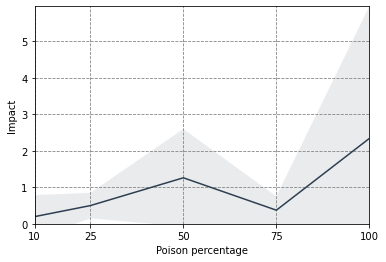

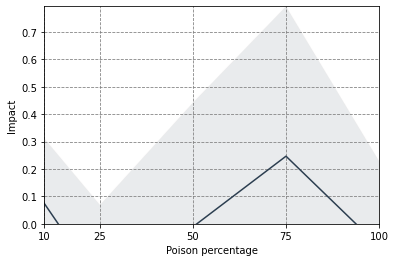

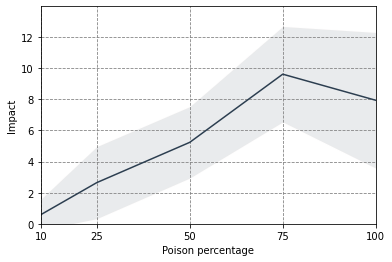

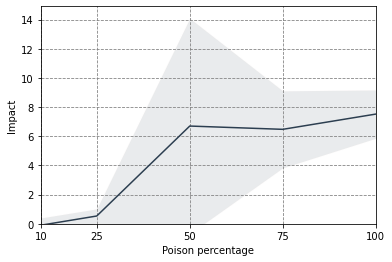

In [479]:
avg_new=np.average(np.array(impacts_new), axis=0)
stdev_new=np.std(np.array(impacts_new), axis=0)
complexity_new_avg = np.average(np.array(complexity_new), axis=0)
complexity_new_st = np.std(np.array(complexity_new), axis=0)


avg_existing=np.average(np.array(impacts_existing), axis=0)
stdev_existing=np.std(np.array(impacts_existing), axis=0)
complexity_existing_avg = np.average(np.array(complexity_existing), axis=0)
complexity_existing_st = np.std(np.array(complexity_existing_avg), axis=0)

avg_swap=np.average(np.array(impacts_swap), axis=0)
stdev_swap=np.std(np.array(impacts_swap), axis=0)
complexity_swap_avg = np.average(np.array(complexity_swap), axis=0)
complexity_swap_st = np.std(np.array(complexity_swap), axis=0)

avg_target=np.average(np.array(impacts_target), axis=0)
stdev_target=np.std(np.array(impacts_target), axis=0)
complexity_target_avg = np.average(np.array(complexity_target), axis=0)
complexity_target_st = np.std(np.array(complexity_target), axis=0)

draw_graph(x=[10,25,50,75,100], y_list = [avg_new], 
           err_list = [stdev_new], xlabel = "Poison percentage", 
           ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg_new)+max(stdev_new)], 
           is_legend=False, facecolor_list=['#2C3E50','#6C3483','#27AE60','#E67E22'], 
           edgecolor_list=['#F9EBEA','#F8F9F9','#EBF5FB','#E9F7EF'], alpha=0.1, thresh_on=False)


draw_graph(x=[10,25,50,75,100], y_list = [avg_existing], 
           err_list = [stdev_existing], xlabel = "Poison percentage", 
           ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg_existing)+max(stdev_existing)], 
           is_legend=False, facecolor_list=['#2C3E50','#6C3483','#27AE60','#E67E22'], 
           edgecolor_list=['#F9EBEA','#F8F9F9','#EBF5FB','#E9F7EF'], alpha=0.1, thresh_on=False)


draw_graph(x=[10,25,50,75,100], y_list = [avg_swap], 
           err_list = [stdev_swap], xlabel = "Poison percentage", 
           ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg_swap)+max(stdev_swap)], 
           is_legend=False, facecolor_list=['#2C3E50','#6C3483','#27AE60','#E67E22'], 
           edgecolor_list=['#F9EBEA','#F8F9F9','#EBF5FB','#E9F7EF'], alpha=0.1, thresh_on=False)

draw_graph(x=[10,25,50,75,100], y_list = [avg_target], 
           err_list = [stdev_target], xlabel = "Poison percentage", 
           ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg_target)+max(stdev_target)], 
           is_legend=False, facecolor_list=['#2C3E50','#6C3483','#27AE60','#E67E22'], 
           edgecolor_list=['#F9EBEA','#F8F9F9','#EBF5FB','#E9F7EF'], alpha=0.1, thresh_on=False)


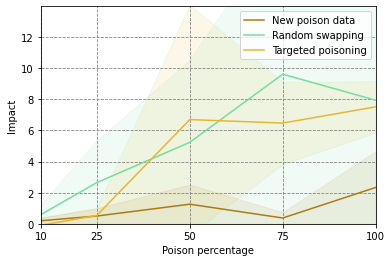

In [352]:
draw_graph(x=[10,25,50,75,100], y_list = [avg_new, avg_swap, avg_target], 
           err_list = [avg_new, avg_swap,stdev_target], label_list=['New poison data','Random swapping','Targeted poisoning'],
            xlabel = "Poison percentage", 
           ylabel = "Impact", xlim=[10,100], ylim=[0,max(avg_swap)+max(stdev_swap)], 
           is_legend=True, alpha=0.1, thresh_on=False)

In [362]:
impacts_new_2, complexity_new_2 = get_impact_over_range_of_poisoning(poison_range=[150,200], num_exp=5, poison_type='new_example',target_bias_class=None)
avg_new_2=np.average(np.array(impacts_new_2), axis=0)
stdev_new_2=np.std(np.array(impacts_new_2), axis=0)

In [363]:
impacts_new_3, complexity_new_3 = get_impact_over_range_of_poisoning(poison_range=[300,500], num_exp=5, poison_type='new_example',target_bias_class=None)
avg_new_3=np.average(np.array(impacts_new_3), axis=0)
stdev_new_3=np.std(np.array(impacts_new_3), axis=0)

In [364]:
impacts_new_4, complexity_new_4 = get_impact_over_range_of_poisoning(poison_range=[800,1000], num_exp=5, poison_type='new_example',target_bias_class=None)
avg_new_4=np.average(np.array(impacts_new_4), axis=0)
stdev_new_4=np.std(np.array(impacts_new_4), axis=0)

In [425]:
impacts_new_5, complexity_new_5 = get_impact_over_range_of_poisoning(poison_range=[1250,1500], num_exp=5, poison_type='new_example',target_bias_class=None)
avg_new_5=np.average(np.array(impacts_new_5), axis=0)
stdev_new_5=np.std(np.array(impacts_new_5), axis=0)

running experiment: 0
poisoning percentage: 1250
4/4 [==============================] - 0s 3ms/step
accuracy original: 0.97
accuracy poisoned: 0.87
f1 original: 0.93
f1 poisoned: 0.60
poisoning percentage: 1500
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.95
accuracy poisoned: 0.89
f1 original: 0.90
f1 poisoned: 0.45
running experiment: 1
poisoning percentage: 1250
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.98
accuracy poisoned: 0.90
f1 original: 0.94
f1 poisoned: 0.73
poisoning percentage: 1500
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.94
accuracy poisoned: 0.89
f1 original: 0.83
f1 poisoned: 0.65
running experiment: 2
poisoning percentage: 1250
4/4 [==============================] - 0s 1ms/step
accuracy original: 0.95
accuracy poisoned: 0.90
f1 original: 0.90
f1 poisoned: 0.67
poisoning percentage: 1500
4/4 [==============================] - 0s 999us/step
accuracy original: 0.96
accuracy poisoned: 0

[[0.08823529411764706,
  0.19827586206896552,
  0.33253588516746413,
  0.42827868852459017,
  0.5],
 [0.08823529411764706,
  0.19827586206896552,
  0.33253588516746413,
  0.42827868852459017,
  0.5],
 [0.08823529411764706,
  0.19827586206896552,
  0.33253588516746413,
  0.42827868852459017,
  0.5],
 [0.08823529411764706,
  0.19827586206896552,
  0.33253588516746413,
  0.42827868852459017,
  0.5],
 [0.08823529411764706,
  0.19827586206896552,
  0.33253588516746413,
  0.42827868852459017,
  0.5]]

In [428]:
avg_impacts_new_all = avg_new.copy()
stdev_impacts_new_all = stdev_new.copy()

for i in [avg_new_2, avg_new_3, avg_new_4, avg_new_5]:
    avg_impacts_new_all= np.append(avg_impacts_new_all,i,0)

for i in [stdev_new_2, stdev_new_3, stdev_new_4, stdev_new_5]:
    stdev_impacts_new_all=np.append(stdev_impacts_new_all,i,0)

complexity_new_all = np.array([])

for i in [complexity_new,complexity_new_2,complexity_new_3,complexity_new_4,complexity_new_5]:
    complexity_new_all = np.append(complexity_new_all, i[0],0)

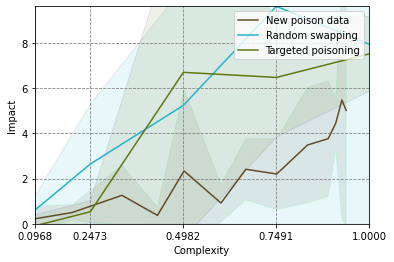

In [503]:
draw_graph_diff_x_plots(x_list=[complexity_new_all,complexity_swap[0],complexity_target[0]], y_list = [avg_impacts_new_all, avg_swap, avg_target], 
           err_list = [stdev_impacts_new_all, avg_swap, stdev_target], label_list=['New poison data','Random swapping','Targeted poisoning'],
            xlabel = "Complexity", 
           ylabel = "Impact", xlim=[0.1,1], ylim=[0,max(avg_swap)], 
           is_legend=True, alpha=0.1, thresh_on=False)

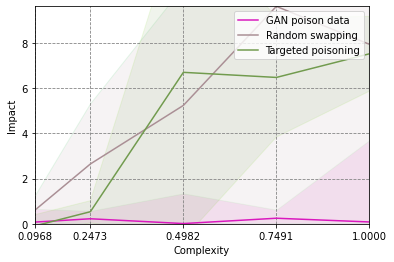

In [506]:
draw_graph_diff_x_plots(x_list=[complexity_swap[0],complexity_swap[0],complexity_target[0]], y_list = [[abs(i) for i in avg_existing], avg_swap, avg_target], 
           err_list = [stdev_impacts_new_all, avg_swap, stdev_target], label_list=['GAN poison data','Random swapping','Targeted poisoning'],
            xlabel = "Complexity", 
           ylabel = "Impact", xlim=[0.1,1], ylim=[0,max(avg_swap)], 
           is_legend=True, alpha=0.1, thresh_on=False)

In [380]:
avg_impacts_new_all

array([0.1962156 , 0.49870361, 1.25993991, 0.3725955 , 2.33854715,
       0.91755501, 2.41137653, 2.20331607, 3.48827085, 3.76634706,
       4.44279259])

In [378]:
complexity_new_all

array([0.08823529, 0.19827586, 0.33253589, 0.42827869, 0.5       ,
       0.59971306, 0.66666667, 0.75      , 0.83333333, 0.88888889,
       0.90909091])

In [373]:
avg_impacts_new_all

array([0.1962156 , 0.49870361, 1.25993991, 0.3725955 , 2.33854715,
       0.91755501, 2.41137653, 2.20331607, 3.48827085, 3.76634706,
       4.44279259])

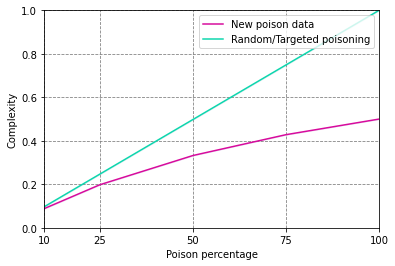

In [476]:
draw_graph(x=[10,25,50,75,100], y_list = [complexity_new_avg, complexity_target_avg], 
           err_list = [complexity_new_st, complexity_target_st], label_list=['New poison data','Random/Targeted poisoning'],
            xlabel = "Poison percentage", 
           ylabel = "Complexity", xlim=[10,100], ylim=[0,max(complexity_swap_avg)+max(complexity_target_st)], 
           is_legend=True, alpha=0.1, thresh_on=False)

In [ ]:
draw_graph(x=[10,25,50,75,100], y_list = [complexity_new_avg, complexity_swap_avg, complexity_target_avg], 
           err_list = [complexity_new_st, complexity_swap_st, complexity_target_st], label_list=['New poison data','Random swapping','Targeted poisoning'],
            xlabel = "Poison percentage", 
           ylabel = "Complexity", xlim=[10,100], ylim=[0,max(complexity_swap_avg)+max(complexity_target_st)], 
           is_legend=True, alpha=0.1, thresh_on=False)

In [348]:
complexity_new

[[0.08823529411764706,
  0.19827586206896552,
  0.33253588516746413,
  0.42827868852459017,
  0.5],
 [0.08823529411764706,
  0.19827586206896552,
  0.33253588516746413,
  0.42827868852459017,
  0.5],
 [0.08823529411764706,
  0.19827586206896552,
  0.33253588516746413,
  0.42827868852459017,
  0.5],
 [0.08823529411764706,
  0.19827586206896552,
  0.33253588516746413,
  0.42827868852459017,
  0.5],
 [0.08823529411764706,
  0.19827586206896552,
  0.33253588516746413,
  0.42827868852459017,
  0.5]]

In [347]:
complexity_new_avg

array([0.08823529, 0.19827586, 0.33253589, 0.42827869, 0.5       ])

In [346]:
complexity_new

[[0.08823529411764706,
  0.19827586206896552,
  0.33253588516746413,
  0.42827868852459017,
  0.5],
 [0.08823529411764706,
  0.19827586206896552,
  0.33253588516746413,
  0.42827868852459017,
  0.5],
 [0.08823529411764706,
  0.19827586206896552,
  0.33253588516746413,
  0.42827868852459017,
  0.5],
 [0.08823529411764706,
  0.19827586206896552,
  0.33253588516746413,
  0.42827868852459017,
  0.5],
 [0.08823529411764706,
  0.19827586206896552,
  0.33253588516746413,
  0.42827868852459017,
  0.5]]

In [339]:
complexity_swap_avg

array([0.09677419, 0.24731183, 0.49820789, 0.74910394, 1.        ])

In [340]:
complexity_target_avg

array([0.09677419, 0.24731183, 0.49820789, 0.74910394, 1.        ])

In [345]:
complexity_new_st

array([0.08823529, 0.19827586, 0.33253589, 0.42827869, 0.5       ])

In [337]:
import csv

write_files=[impacts_new, complexity_new, impacts_swap, complexity_swap, 
             impacts_target, complexity_target]
file_name=['impacts_new', 'complexity_new', 'impacts_swap', 'complexity_swap', 
             'impacts_target', 'complexity_target']
for i in range(len(write_files)):
  fname=file_name[i]
  with open("%s.csv"%(fname), "w", newline="") as f:
      writer = csv.writer(f)
      writer.writerows(write_files[i])

## XAI Metrics

True
9/9 [==============================] - 0s 1ms/step - loss: 0.3132 - accuracy: 0.8495
Accuracy: 84.95
4/4 [==============================] - 0s 2ms/step
Wrong prediction at sample 58
Prediction: [0 0 0] but expected output: [0 1 0]
Wrong prediction at sample 60
Prediction: [0 0 0] but expected output: [0 1 0]
Wrong prediction at sample 61
Prediction: [0 0 0] but expected output: [0 1 0]
Wrong prediction at sample 63
Prediction: [0 0 0] but expected output: [0 1 0]
Wrong prediction at sample 67
Prediction: [0 0 0] but expected output: [0 0 1]
Wrong prediction at sample 68
Prediction: [1 0 0] but expected output: [0 0 1]
Wrong prediction at sample 69
Prediction: [1 0 0] but expected output: [0 0 1]
Wrong prediction at sample 70
Prediction: [0 0 0] but expected output: [0 0 1]
Wrong prediction at sample 71
Prediction: [0 0 0] but expected output: [0 0 1]
Wrong prediction at sample 74
Prediction: [1 0 0] but expected output: [0 0 1]
Wrong prediction at sample 75
Prediction: [1 0 0] but

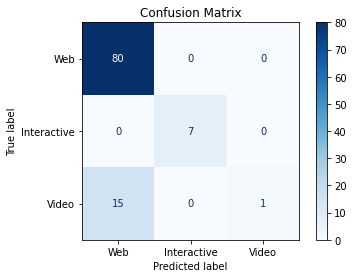

In [334]:
# Define the Keras model
model = Sequential()
model.add(Dense(12, input_shape=(21,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

# Compile the Keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the Keras model on the dataset
# model.fit(X_poison, Y_poison, epochs=150, batch_size=10)
X_train_new, Y_train_new,_,_ = get_poison_set(X_train, Y_train, X_poison, Y_poison, poison_type='random_swapping', percentage=50)
model.fit(X_train_new, Y_train_new, epochs=50, batch_size=10,verbose=0)

# Evaluate the Keras model
_, accuracy = model.evaluate(X_train, Y_train)
print('Accuracy: %.2f' % (accuracy*100))

# Make class predictions with the model
predictions = (model.predict(X_test) > 0.5).astype(int)

nb_errors = 0
nb_tests = len(X_test)
errors = []
for i in range(0,len(X_test)):
	#print('%s (expected %s)' % (predictions[i].tolist(), Y_test[i].tolist()))
	if (predictions[i].tolist() != Y_test[i].tolist()):
		errors.append(i)
		nb_errors += 1

accuracy = (nb_tests - nb_errors) * 100 / nb_tests

for i in errors:
	print("Wrong prediction at sample " + str(i + 1))
	#print(X_test[i])
	print("Prediction: " + str(predictions[i]) + " but expected output: " + str(Y_test[i]))

Y_pred = model.predict(X_test)
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
print("Confusion matrix: \n" + str(cm))

labels = ["Web", "Interactive", "Video"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print("Number of wrong predictions: " + str(nb_errors))
print("Accuracy: " + str(accuracy) + "%")

4/4 [==============================] - 0s 999us/step


Using 103 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/103 [00:00<?, ?it/s]

322/322 [==============================] - 0s 621us/step


  1%|          | 1/103 [00:00<00:44,  2.28it/s]

322/322 [==============================] - 0s 683us/step


  2%|▏         | 2/103 [00:00<00:46,  2.18it/s]

322/322 [==============================] - 0s 716us/step


  3%|▎         | 3/103 [00:01<00:46,  2.16it/s]

322/322 [==============================] - 0s 615us/step


  4%|▍         | 4/103 [00:01<00:44,  2.21it/s]

322/322 [==============================] - 0s 611us/step


  5%|▍         | 5/103 [00:02<00:43,  2.26it/s]

322/322 [==============================] - 0s 648us/step


  6%|▌         | 6/103 [00:02<00:43,  2.25it/s]

322/322 [==============================] - 0s 589us/step


  7%|▋         | 7/103 [00:03<00:42,  2.28it/s]

322/322 [==============================] - 0s 601us/step


  8%|▊         | 8/103 [00:03<00:41,  2.30it/s]

322/322 [==============================] - 0s 600us/step


  9%|▊         | 9/103 [00:03<00:40,  2.31it/s]

322/322 [==============================] - 0s 603us/step


 10%|▉         | 10/103 [00:04<00:40,  2.32it/s]

322/322 [==============================] - 0s 760us/step


 11%|█         | 11/103 [00:04<00:40,  2.26it/s]

322/322 [==============================] - 0s 597us/step


 12%|█▏        | 12/103 [00:05<00:39,  2.29it/s]

322/322 [==============================] - 0s 597us/step


 13%|█▎        | 13/103 [00:05<00:38,  2.31it/s]

322/322 [==============================] - 0s 598us/step


 14%|█▎        | 14/103 [00:06<00:38,  2.32it/s]

322/322 [==============================] - 0s 607us/step


 15%|█▍        | 15/103 [00:06<00:37,  2.33it/s]

322/322 [==============================] - 0s 692us/step


 16%|█▌        | 16/103 [00:07<00:38,  2.29it/s]

322/322 [==============================] - 0s 666us/step


 17%|█▋        | 17/103 [00:07<00:38,  2.25it/s]

322/322 [==============================] - 0s 732us/step


 17%|█▋        | 18/103 [00:07<00:38,  2.20it/s]

322/322 [==============================] - 0s 690us/step


 18%|█▊        | 19/103 [00:08<00:38,  2.17it/s]

322/322 [==============================] - 0s 724us/step


 19%|█▉        | 20/103 [00:08<00:39,  2.10it/s]

322/322 [==============================] - 0s 598us/step


 20%|██        | 21/103 [00:09<00:38,  2.14it/s]

322/322 [==============================] - 0s 632us/step


 21%|██▏       | 22/103 [00:09<00:37,  2.17it/s]

322/322 [==============================] - 0s 691us/step


 22%|██▏       | 23/103 [00:10<00:37,  2.13it/s]

322/322 [==============================] - 0s 660us/step


 23%|██▎       | 24/103 [00:10<00:37,  2.12it/s]

322/322 [==============================] - 0s 656us/step


 24%|██▍       | 25/103 [00:11<00:36,  2.13it/s]

322/322 [==============================] - 0s 747us/step


 25%|██▌       | 26/103 [00:11<00:36,  2.10it/s]

322/322 [==============================] - 0s 680us/step


 26%|██▌       | 27/103 [00:12<00:35,  2.12it/s]

322/322 [==============================] - 0s 671us/step


 27%|██▋       | 28/103 [00:12<00:35,  2.11it/s]

322/322 [==============================] - 0s 717us/step


 28%|██▊       | 29/103 [00:13<00:35,  2.11it/s]

322/322 [==============================] - 0s 666us/step


 29%|██▉       | 30/103 [00:13<00:34,  2.09it/s]

322/322 [==============================] - 0s 677us/step


 30%|███       | 31/103 [00:14<00:33,  2.13it/s]

322/322 [==============================] - 0s 689us/step


 31%|███       | 32/103 [00:14<00:33,  2.10it/s]

322/322 [==============================] - 0s 611us/step


 32%|███▏      | 33/103 [00:15<00:32,  2.13it/s]

322/322 [==============================] - 0s 693us/step


 33%|███▎      | 34/103 [00:15<00:32,  2.11it/s]

322/322 [==============================] - 0s 703us/step


 34%|███▍      | 35/103 [00:16<00:32,  2.11it/s]

322/322 [==============================] - 0s 731us/step


 35%|███▍      | 36/103 [00:16<00:31,  2.10it/s]

322/322 [==============================] - 0s 712us/step


 36%|███▌      | 37/103 [00:16<00:31,  2.10it/s]

322/322 [==============================] - 0s 728us/step


 37%|███▋      | 38/103 [00:17<00:31,  2.09it/s]

322/322 [==============================] - 0s 628us/step


 38%|███▊      | 39/103 [00:17<00:30,  2.11it/s]

322/322 [==============================] - 0s 662us/step


 39%|███▉      | 40/103 [00:18<00:30,  2.06it/s]

322/322 [==============================] - 0s 696us/step


 40%|███▉      | 41/103 [00:18<00:29,  2.07it/s]

322/322 [==============================] - 0s 671us/step


 41%|████      | 42/103 [00:19<00:29,  2.10it/s]

322/322 [==============================] - 0s 652us/step


 42%|████▏     | 43/103 [00:19<00:28,  2.11it/s]

322/322 [==============================] - 0s 684us/step


 43%|████▎     | 44/103 [00:20<00:27,  2.12it/s]

322/322 [==============================] - 0s 700us/step


 44%|████▎     | 45/103 [00:20<00:27,  2.09it/s]

322/322 [==============================] - 0s 699us/step


 45%|████▍     | 46/103 [00:21<00:27,  2.10it/s]

322/322 [==============================] - 0s 689us/step


 46%|████▌     | 47/103 [00:21<00:26,  2.08it/s]

322/322 [==============================] - 0s 701us/step


 47%|████▋     | 48/103 [00:22<00:26,  2.09it/s]

322/322 [==============================] - 0s 598us/step


 48%|████▊     | 49/103 [00:22<00:25,  2.14it/s]

322/322 [==============================] - 0s 622us/step


 49%|████▊     | 50/103 [00:23<00:24,  2.17it/s]

322/322 [==============================] - 0s 654us/step


 50%|████▉     | 51/103 [00:23<00:23,  2.18it/s]

322/322 [==============================] - 0s 665us/step


 50%|█████     | 52/103 [00:24<00:23,  2.18it/s]

322/322 [==============================] - 0s 675us/step


 51%|█████▏    | 53/103 [00:24<00:23,  2.17it/s]

322/322 [==============================] - 0s 661us/step


 52%|█████▏    | 54/103 [00:24<00:22,  2.16it/s]

322/322 [==============================] - 0s 657us/step


 53%|█████▎    | 55/103 [00:25<00:22,  2.17it/s]

322/322 [==============================] - 0s 680us/step


 54%|█████▍    | 56/103 [00:25<00:21,  2.19it/s]

322/322 [==============================] - 0s 742us/step


 55%|█████▌    | 57/103 [00:26<00:21,  2.15it/s]

322/322 [==============================] - 0s 648us/step


 56%|█████▋    | 58/103 [00:26<00:20,  2.16it/s]

322/322 [==============================] - 0s 626us/step


 57%|█████▋    | 59/103 [00:27<00:20,  2.19it/s]

322/322 [==============================] - 0s 669us/step


 58%|█████▊    | 60/103 [00:27<00:19,  2.19it/s]

322/322 [==============================] - 0s 660us/step


 59%|█████▉    | 61/103 [00:28<00:19,  2.18it/s]

322/322 [==============================] - 0s 651us/step


 60%|██████    | 62/103 [00:28<00:18,  2.20it/s]

322/322 [==============================] - 0s 645us/step


 61%|██████    | 63/103 [00:29<00:18,  2.21it/s]

322/322 [==============================] - 0s 670us/step


 62%|██████▏   | 64/103 [00:29<00:17,  2.21it/s]

322/322 [==============================] - 0s 648us/step


 63%|██████▎   | 65/103 [00:29<00:17,  2.18it/s]

322/322 [==============================] - 0s 580us/step


 64%|██████▍   | 66/103 [00:30<00:16,  2.24it/s]

322/322 [==============================] - 0s 814us/step


 65%|██████▌   | 67/103 [00:30<00:16,  2.16it/s]

322/322 [==============================] - 0s 642us/step


 66%|██████▌   | 68/103 [00:31<00:16,  2.18it/s]

322/322 [==============================] - 0s 676us/step


 67%|██████▋   | 69/103 [00:31<00:15,  2.17it/s]

322/322 [==============================] - 0s 639us/step


 68%|██████▊   | 70/103 [00:32<00:15,  2.17it/s]

322/322 [==============================] - 0s 650us/step


 69%|██████▉   | 71/103 [00:32<00:14,  2.18it/s]

322/322 [==============================] - 0s 588us/step


 70%|██████▉   | 72/103 [00:33<00:13,  2.25it/s]

322/322 [==============================] - 0s 651us/step


 71%|███████   | 73/103 [00:33<00:13,  2.22it/s]

322/322 [==============================] - 0s 663us/step


 72%|███████▏  | 74/103 [00:34<00:13,  2.19it/s]

322/322 [==============================] - 0s 671us/step


 73%|███████▎  | 75/103 [00:34<00:12,  2.18it/s]

322/322 [==============================] - 0s 706us/step


 74%|███████▍  | 76/103 [00:35<00:12,  2.14it/s]

322/322 [==============================] - 0s 671us/step


 75%|███████▍  | 77/103 [00:35<00:12,  2.12it/s]

322/322 [==============================] - 0s 651us/step


 76%|███████▌  | 78/103 [00:36<00:11,  2.12it/s]

322/322 [==============================] - 0s 704us/step


 77%|███████▋  | 79/103 [00:36<00:11,  2.12it/s]

322/322 [==============================] - 0s 643us/step


 78%|███████▊  | 80/103 [00:36<00:10,  2.15it/s]

322/322 [==============================] - 0s 673us/step


 79%|███████▊  | 81/103 [00:37<00:10,  2.16it/s]

322/322 [==============================] - 0s 693us/step


 80%|███████▉  | 82/103 [00:37<00:09,  2.15it/s]

322/322 [==============================] - 0s 749us/step


 81%|████████  | 83/103 [00:38<00:09,  2.11it/s]

322/322 [==============================] - 0s 704us/step


 82%|████████▏ | 84/103 [00:38<00:09,  2.09it/s]

322/322 [==============================] - 0s 699us/step


 83%|████████▎ | 85/103 [00:39<00:08,  2.11it/s]

322/322 [==============================] - 0s 682us/step


 83%|████████▎ | 86/103 [00:39<00:08,  2.11it/s]

322/322 [==============================] - 0s 672us/step


 84%|████████▍ | 87/103 [00:40<00:07,  2.10it/s]

322/322 [==============================] - 0s 654us/step


 85%|████████▌ | 88/103 [00:40<00:07,  2.12it/s]

322/322 [==============================] - 0s 719us/step


 86%|████████▋ | 89/103 [00:41<00:06,  2.11it/s]

322/322 [==============================] - 0s 693us/step


 87%|████████▋ | 90/103 [00:41<00:06,  2.12it/s]

322/322 [==============================] - 0s 720us/step


 88%|████████▊ | 91/103 [00:42<00:05,  2.09it/s]

322/322 [==============================] - 0s 720us/step


 89%|████████▉ | 92/103 [00:42<00:05,  2.07it/s]

322/322 [==============================] - 0s 685us/step


 90%|█████████ | 93/103 [00:43<00:04,  2.08it/s]

322/322 [==============================] - 0s 694us/step


 91%|█████████▏| 94/103 [00:43<00:04,  2.04it/s]

322/322 [==============================] - 0s 693us/step


 92%|█████████▏| 95/103 [00:44<00:03,  2.05it/s]

322/322 [==============================] - 0s 689us/step


 93%|█████████▎| 96/103 [00:44<00:03,  2.03it/s]

322/322 [==============================] - 0s 698us/step


 94%|█████████▍| 97/103 [00:45<00:02,  2.05it/s]

322/322 [==============================] - 0s 656us/step


 95%|█████████▌| 98/103 [00:45<00:02,  2.08it/s]

322/322 [==============================] - 0s 719us/step


 96%|█████████▌| 99/103 [00:46<00:01,  2.05it/s]

322/322 [==============================] - 0s 705us/step


 97%|█████████▋| 100/103 [00:46<00:01,  1.73it/s]

322/322 [==============================] - 0s 711us/step


 98%|█████████▊| 101/103 [00:47<00:01,  1.81it/s]

322/322 [==============================] - 0s 642us/step


 99%|█████████▉| 102/103 [00:47<00:00,  1.91it/s]

322/322 [==============================] - 0s 643us/step


100%|██████████| 103/103 [00:48<00:00,  2.13it/s]


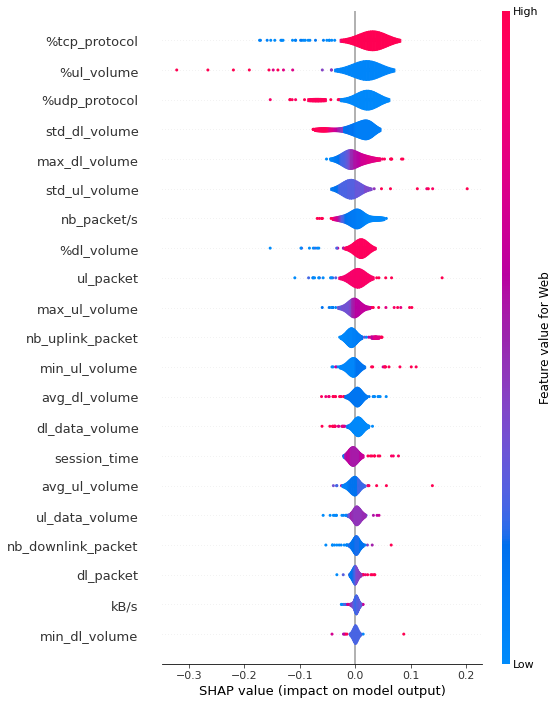

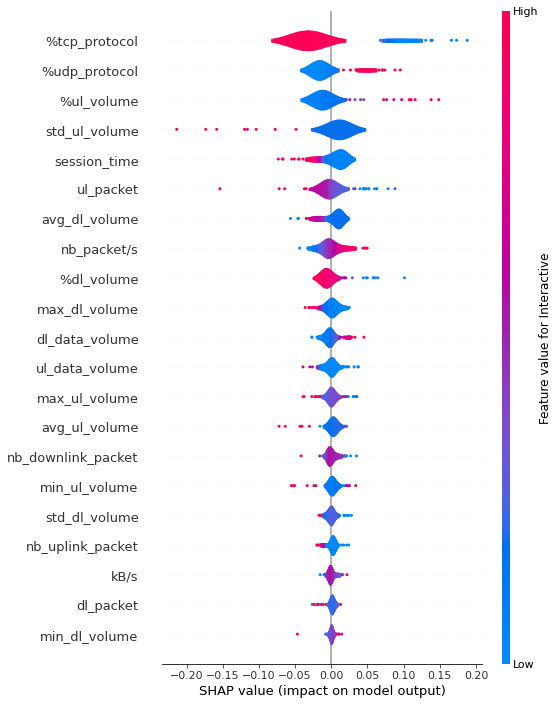

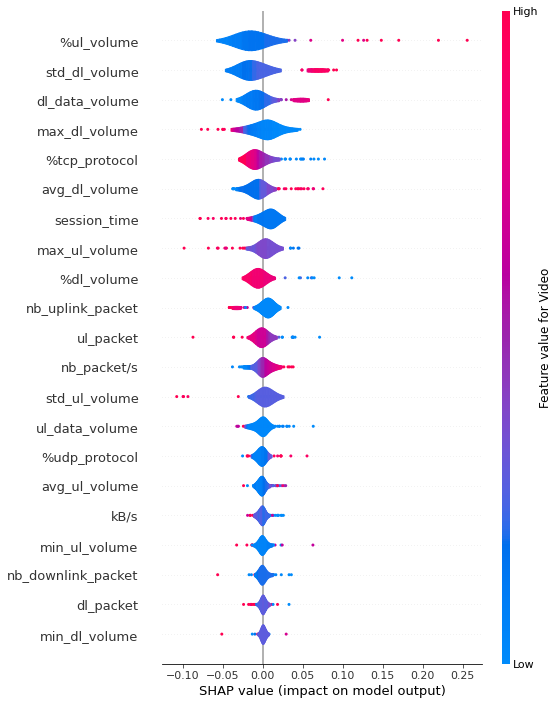

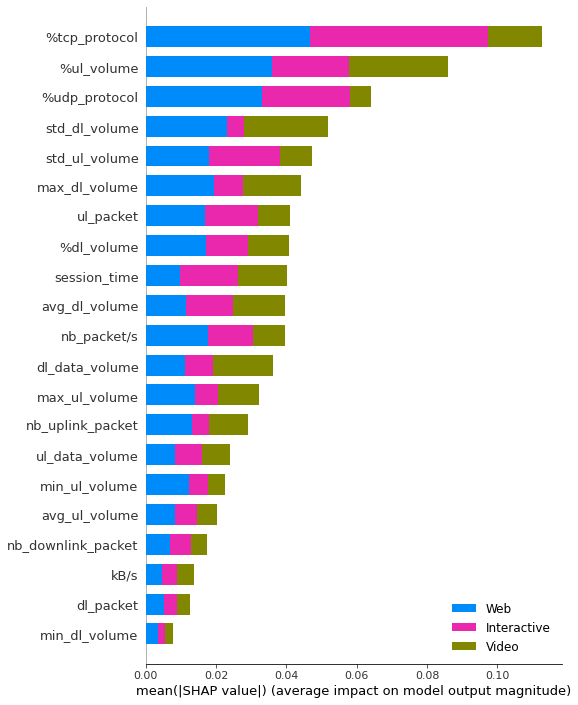

In [335]:
from pydoc import classname
import warnings
import shap

classes=['Web', 'Interactive', 'Video']
explainer = shap.KernelExplainer(model.predict, X_test)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(X_test, nsamples=100)
#print(shap_values)

shap.summary_plot(shap_values[0], X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for Web', plot_type="violin")
shap.summary_plot(shap_values[1], X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for Interactive', plot_type="violin")
shap.summary_plot(shap_values[2], X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for Video', plot_type="violin")

shap.summary_plot(shap_values, X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for all')